In [6]:
import pandas as pd
import geopandas as gpd
# Replace 'your_file.tsv' with the actual filename and path
# file_path = r"D:\Document\SemesterProject\New_case\VD\TS_no_ground_under_building\morges_default_TS.tsv"
file_path=r"D:\Document\SemesterProject\morges_result_default\morges_result_default_TS.out"
# Read the TSV file into a pandas DataFrame
df = pd.read_csv(file_path, delimiter='\t')

# Display the DataFrame



In [7]:
df.info()

df_without_null_columns = df.dropna(axis=1)

df_without_null_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Columns: 3441 entries, #2(280064733):0:Ke(W/(m2K)) to Unnamed: 3440
dtypes: float64(3441)
memory usage: 230.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Columns: 3440 entries, #2(280064733):0:Ke(W/(m2K)) to NA(NA):383606():Tos(°C)
dtypes: float64(3440)
memory usage: 229.9 MB


In [3]:
last_column = df.iloc[:, -2]

last_column

0      -3.00182
1      -3.41108
2      -3.50968
3      -3.83842
4      -3.96732
         ...   
8755   -2.51191
8756   -2.63431
8757   -2.45867
8758   -2.13055
8759   -2.25299
Name: NA(NA):383592():Tos(°C), Length: 8760, dtype: float64

In [4]:
def AST(envelope, df, ground_data):
    df_without_null_columns = df.dropna(axis=1)
    columns_without_ke = [col for col in df_without_null_columns.columns if 'Ke' not in col]
    filtered_columns = df_without_null_columns[columns_without_ke]
    AVG_t = filtered_columns.mean()
    AVG_t_df = pd.DataFrame({'T': AVG_t.values}, index=AVG_t.index)
    surface_id = AVG_t_df.index.to_series().str.split(':', expand=True)[1].str.split('(', expand=True)[0].astype(int)
    AVG_t_df['surface_id'] = surface_id
    
    T_grounds = AVG_t_df.filter(like='NA', axis=0)
    merged_T_grounds = pd.merge(T_grounds, ground_data[['gid', 'geometry']], left_on='surface_id', right_on='gid', how='left')
    merged_T_grounds = merged_T_grounds.drop(columns='gid')
    grounds_AST = gpd.GeoDataFrame(merged_T_grounds, geometry='geometry')

    weighted_avg_T_list=[]
    convex_hull_list=[]
    building_id=AVG_t.columns.to_series().apply(lambda col_name: col_name[0:2])
    for r in building_id.values:
        single_building = AVG_t_df.filter(regex=f'^{r}', axis=0)
        weighted_avg_T = (single_building['T'] * envelope.loc[single_building['surface_id']]['geometry'].area).sum() / envelope.loc[single_building['surface_id']]['geometry'].area.sum()
        building_gmt=envelope.loc[single_building['surface_id']]['geometry'].unary_union.convex_hull
        weighted_avg_T_list.append(weighted_avg_T)
        convex_hull_list.append(building_gmt)
    buildings_AST = gpd.GeoDataFrame({'AST': weighted_avg_T_list, 'geometry': convex_hull_list})
    #surface_id = single_building.columns.to_series().apply(lambda col_name: col_name[13:15])
    return grounds_AST, buildings_AST
        
    #     surface_id.values

In [ ]:
def AST_(envelope, df, ground_data):
    df_without_null_columns = df.dropna(axis=1)
    columns_without_ke = [col for col in df_without_null_columns.columns if 'Ke' not in col]
    filtered_columns = df_without_null_columns[columns_without_ke]
    AVG_t = filtered_columns.mean()
    AVG_t_df = pd.DataFrame({'T': AVG_t.values}, index=AVG_t.index)
    surface_id = AVG_t_df.index.to_series().str.split(':', expand=True)[1].str.split('(', expand=True)[0].astype(int)
    AVG_t_df['surface_id'] = surface_id
    
    T_grounds = AVG_t_df.filter(like='NA', axis=0)
    merged_T_grounds = pd.merge(T_grounds, ground_data[['gid', 'geometry']], left_on='surface_id', right_on='gid', how='left')
    merged_T_grounds = merged_T_grounds.drop(columns='gid')
    merged_T_grounds = merged_T_grounds.drop(columns='surface_id')
    grounds_AST = gpd.GeoDataFrame(merged_T_grounds, geometry='geometry')

    weighted_avg_T_list=[]
    boundry_list=[]
    T_buildings = AVG_t_df.drop(index=T_grounds.index)
    building_id=T_buildings.index.to_series().str.split('(', expand=True)[0].unique()
    for r in building_id:
        single_building = T_buildings[T_buildings.index.str.split('(').str[0] == str(r)]
        m1=single_building['surface_id']
        m2=envelope.loc[m1]['geometry']
        s1=m2.area
        T=single_building['T']
        mul=s1.values * T.values
        n=mul.sum()
        m=s1.sum()
        weighted_avg_T=n/m
        # weighted_avg_T = (single_building['T'].values * envelope.loc[single_building['surface_id']]['geometry'].area.values).sum() / envelope.loc[single_building['surface_id']]['geometry'].area.sum()
        building_gmt=envelope.loc[single_building['surface_id']]['geometry'].unary_union #.convex_hull
        weighted_avg_T_list.append(weighted_avg_T)
        boundry_list.append(building_gmt)
    buildings_AST = gpd.GeoDataFrame(geometry=boundry_list, crs='EPSG:2056')
    buildings_AST['T'] = weighted_avg_T_list
    concatenated_df = pd.concat([buildings_AST, grounds_AST], ignore_index=True)
    result_gdf = gpd.GeoDataFrame(concatenated_df, geometry='geometry')

    return grounds_AST, buildings_AST, result_gdf

In [8]:
df_without_null_columns = df.dropna(axis=1)

columns_without_ke = [col for col in df_without_null_columns.columns if 'Ke' not in col]
filtered_columns = df_without_null_columns[columns_without_ke]
AVG_t = filtered_columns.mean()
print(AVG_t.min())
print(AVG_t.max())
print('-------')

AVG_t_df = pd.DataFrame({'T': AVG_t.values}, index=AVG_t.index)
surface_id = AVG_t_df.index.to_series().str.split(':', expand=True)[1].str.split('(', expand=True)[0].astype(int)
AVG_t_df['surface_id'] = surface_id

T_grounds = AVG_t_df.filter(like='NA', axis=0)
T_buildings = AVG_t_df.drop(index=T_grounds.index)

building_id=T_buildings.index.to_series().str.split('(', expand=True)[0].unique()
print(building_id)

temp=0
for r in building_id:
    # print(r)
    single_building = T_buildings[T_buildings.index.str.split('(').str[0] == str(r)]
    temp+=single_building.shape[0]
    print(single_building)
print(temp)
# building_id=AVG_t_df.index.to_series().str.split('(', expand=True)[0].unique()
# T_grounds = AVG_t_df.filter(like='NA', axis=0)
# T_buildings = AVG_t_df.drop(index=T_grounds.index)
# b_surface_id = T_buildings.columns.to_series().str.split(':', expand=True)[1].str[:2].str.split('(', expand=True)[0].astype(int)
# g_surface_id = 

# filtered_columns
# AVG_t_df
building_id
# T_grounds
# T_buildings
# if :

# else:
#     surface_id = AVG_t.index.to_series().str.split(':', expand=True)[1].str[:2].astype(int)
# AVG_t = AVG_t.reset_index()
# AVG_t['surface_id'] = surface_id

# AVG_t

8.39956799053162
18.881922294871117
-------
['2' '21' '22' '44' '51']
                                    T  surface_id
2(280064733):192():Tos(°C)  14.915907         192
2(280064733):193():Tos(°C)  13.637696         193
2(280064733):194():Tos(°C)  12.909623         194
2(280064733):195():Tos(°C)  12.394111         195
2(280064733):196():Tos(°C)  12.921031         196
...                               ...         ...
2(280064733):187():Tos(°C)  16.909794         187
2(280064733):188():Tos(°C)  16.908093         188
2(280064733):189():Tos(°C)  16.906893         189
2(280064733):190():Tos(°C)  16.909221         190
2(280064733):191():Tos(°C)  16.908658         191

[68 rows x 2 columns]
                                   T  surface_id
21(798312):4825():Tos(°C)  15.839282        4825
21(798312):4826():Tos(°C)  15.337100        4826
21(798312):4827():Tos(°C)  15.660276        4827
21(798312):4828():Tos(°C)  14.788136        4828
21(798312):4829():Tos(°C)  15.068119        4829
...          

array(['2', '21', '22', '44', '51'], dtype=object)

<Axes: >

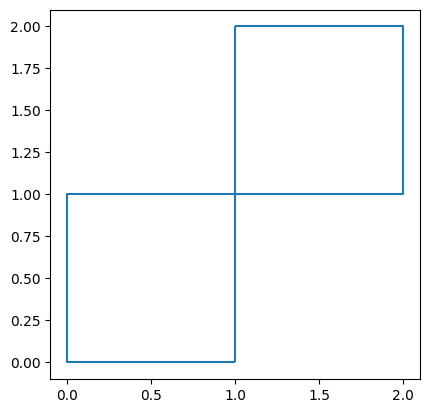

In [23]:
import geopandas as gpd
from shapely.geometry import Polygon

# Create a GeoDataFrame with some example geometries
data = {'geometry': [Polygon([(0, 0), (1, 0), (1, 1), (0, 1)]),
                      Polygon([(1, 1), (2, 1), (2, 2), (1, 2)])]}
gdf = gpd.GeoDataFrame(data)

# Compute the overall boundary of all geometries
overall_boundary = gdf['geometry'].unary_union

# Create a GeoDataFrame with the overall boundary
overall_boundary_gdf = gpd.GeoDataFrame(geometry=[overall_boundary])

# Display the GeoDataFrame with the overall boundary
overall_boundary_gdf.boundary.plot()


In [24]:
is_column_repeat = AVG_t_df['surface_id'].duplicated()
repeat_values = AVG_t_df['surface_id'][is_column_repeat]
# Check if any value is True in the is_column_repeat Series
if is_column_repeat.any():
    print(f"The column  has repeat values.")
else:
    print(f"The column does not have repeat values.")

repeat_values

The column does not have repeat values.


Series([], Name: surface_id, dtype: int32)

In [25]:
target_prefix = '1\(280103503\)'
filtered_columns = df.filter(regex=f'^{target_prefix}')
result_series = filtered_columns.columns.to_series().apply(lambda col_name: col_name[13:15])
result_series2 = filtered_columns.columns.to_series().str.split(':', expand=True)[1].str[:2].astype(int)
# Display the DataFrame with columns starting with the target substring

result_series2

1(280103503):51():Tos(°C)    51
1(280103503):52():Tos(°C)    52
1(280103503):53():Tos(°C)    53
1(280103503):54():Tos(°C)    54
1(280103503):55():Tos(°C)    55
                             ..
1(280103503):46():Tos(°C)    46
1(280103503):47():Tos(°C)    47
1(280103503):48():Tos(°C)    48
1(280103503):49():Tos(°C)    49
1(280103503):50():Tos(°C)    50
Name: 1, Length: 122, dtype: int32

In [26]:
result_series = df.columns.to_series().apply(lambda col_name: col_name[13:15])

# Display the resulting Series with extracted characters
print(result_series)



#1(280103503):0:Ke(W/(m2K))    :0
1(280103503):51():Tos(°C)      51
1(280103503):52():Tos(°C)      52
1(280103503):53():Tos(°C)      53
1(280103503):54():Tos(°C)      54
                               ..
NA(NA):383595():Tos(°C)        ()
NA(NA):383594():Tos(°C)        ()
NA(NA):383593():Tos(°C)        ()
NA(NA):383592():Tos(°C)        ()
Unnamed: 8346                    
Length: 8347, dtype: object


In [27]:
target_prefix = '1(280103503):'

# Use the filter method with a custom condition to check for the starting substring
filtered_columns1 = df.filter(like=target_prefix, axis=1)

# Display the DataFrame with columns starting with the target substring
print(filtered_columns1.head(1))

   #1(280103503):0:Ke(W/(m2K))  1(280103503):51():Tos(°C)  \
0                      3.21132                   -4.35559   

   1(280103503):52():Tos(°C)  1(280103503):53():Tos(°C)  \
0                   -5.25697                   -5.24395   

   1(280103503):54():Tos(°C)  1(280103503):55():Tos(°C)  \
0                   -5.44167                   -3.86117   

   1(280103503):56():Tos(°C)  1(280103503):57():Tos(°C)  \
0                   -2.33987                   -3.11559   

   1(280103503):58():Tos(°C)  1(280103503):59():Tos(°C)  ...  \
0                   -2.51586                    -3.3385  ...   

   1(280103503):41():Tos(°C)  1(280103503):42():Tos(°C)  \
0                   -4.11917                   -3.36979   

   1(280103503):43():Tos(°C)  1(280103503):44():Tos(°C)  \
0                   -3.68566                   -3.57998   

   1(280103503):45():Tos(°C)  1(280103503):46():Tos(°C)  \
0                   -3.96089                   -3.54769   

   1(280103503):47():Tos(°C)  1(28

In [2]:
import pandas as pd
import geopandas as gpd

gpkg_filepath = r"D:\Document\SemesterProject\New_case\VD\study_area\morges.gpkg"  
dfT = gpd.read_file(gpkg_filepath, layer = 'all_AST_dft')
s1= gpd.read_file(gpkg_filepath, layer = 'all_AST_s1')

dfT

,T,geometry
0,17.399529,"POLYGON Z ((2527430.521 1151198.760 381.625, 2..."
1,17.361214,MULTIPOLYGON Z (((2527380.345 1151161.012 394....
2,17.068752,"POLYGON Z ((2527387.609 1151207.674 381.353, 2..."
3,16.561497,"POLYGON Z ((2527374.283 1151187.996 381.113, 2..."
4,17.141480,"POLYGON Z ((2527364.092 1151202.762 387.742, 2..."
...,...,...
2820,13.710873,"POLYGON Z ((2527379.000 1151231.000 380.350, 2..."
2821,13.767433,"POLYGON Z ((2527377.000 1151231.000 380.520, 2..."
2822,13.638836,"POLYGON Z ((2527377.000 1151231.000 380.520, 2..."
2823,13.688297,"POLYGON Z ((2527375.000 1151231.000 380.710, 2..."


In [3]:
s1

,T,geometry
0,17.400575,"POLYGON Z ((2527430.521 1151198.760 381.625, 2..."
1,17.361424,MULTIPOLYGON Z (((2527380.345 1151161.012 394....
2,17.069933,"POLYGON Z ((2527387.609 1151207.674 381.353, 2..."
3,16.561662,"POLYGON Z ((2527374.283 1151187.996 381.113, 2..."
4,17.142281,"POLYGON Z ((2527364.092 1151202.762 387.742, 2..."
...,...,...
2820,13.711268,"POLYGON Z ((2527379.000 1151231.000 380.350, 2..."
2821,13.767923,"POLYGON Z ((2527377.000 1151231.000 380.520, 2..."
2822,13.638902,"POLYGON Z ((2527377.000 1151231.000 380.520, 2..."
2823,13.688362,"POLYGON Z ((2527375.000 1151231.000 380.710, 2..."


In [6]:
merged_df = gpd.GeoDataFrame(pd.merge(dfT, s1, on='geometry', suffixes=('_dfT', '_s1')))
merged_df['T_difference'] = merged_df['T_s1'] - merged_df['T_dfT']
Dif_df = merged_df[['geometry', 'T_difference']]
Dif_gdf = gpd.GeoDataFrame(Dif_df, geometry='geometry')
Dif_gdf

Dif_gdf.to_file(gpkg_filepath, layer='all_AST_dif', driver='GPKG')

